In [2]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

import numpy as np
import matplotlib.pyplot as plt
import ROOT as r

from tqdm import tqdm_notebook

from scripts.plot_tools import set_default_style
set_default_style()

%connect_info

/home/naodell/work/wbr/analysis
Welcome to JupyROOT 6.14/04
{
  "shell_port": 36277,
  "iopub_port": 35127,
  "stdin_port": 45193,
  "control_port": 50813,
  "hb_port": 54013,
  "ip": "127.0.0.1",
  "key": "90b152d8-178e879205dd328629a0c39b",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-1a83ba13-16f2-478f-9971-580f184a1d1f.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# Estimating uncertainty on Drell-Yan cross-section from PDF uncertainty

The uncertainty on the Drell-Yan production cross-section can be estimated by considering the generator level uncertainty of the AMC@NLO simulated sample.  These uncertainties are mainly represented by the uncertainty on the PDF set that is used and the uncertainty on the assumed value of $\alpha_{S}$.  We make use of information stored in the form of LHE weights specifically the MC replicas for the PDFS (ids 2001-2100) and the variation of $\alpha_{s}$ (id 2101-2102).  Accessing these values is described in [Josh Bendavid's talk](https://indico.cern.ch/event/494682/contributions/1172505/attachments/1223578/1800218/mcaod-Feb15-2016.pdf) and the method for propagating their effect through the analysis is described in the [LHC4PDF recommendations](http://arxiv.org/abs/1510.03865).  These PDF variation will modify the estimated efficiency and acceptance of the simulation so to estimate this effect (without having to save the value of all 100 MC replicas for each event), we histogram the MC replicas before applying any selection, and after the selection for each of the channels considered in the analysis.  This is further broken down based on the number of partons in the initial states.  This is done because it is a generator level quantity that should correlate strongly with the number of jets.  In summation, the quantity being estimated in this notebook is:

$$
\delta \epsilon_{channel} = \sqrt{\sum_{\sf i \in MC rep.} \frac{eff_{ch, i} - <eff_{ch}>}{N_{\sf MC rep.} - 1}}
$$

In [15]:
# get the data and convert weighted event counts to efficiencies
selections = ['ee', 'mumu', 'emu', 'etau', 'mutau', 'e4j', 'mu4j']
p_labels = ['PDF', r'$\alpha_{s}$', 
            r'$\mu_{f}$', r'$\mu_{r}$', r'$\mu_{r}, \mu_{f}$',
            'combined'
           ]

In [16]:
# get initial values for each PDF MC replica
root_file = r.TFile('local_data/bltuples/output_pdf.root')
hist = root_file.Get('var_PDF_zjets_m-50_alt')
pdf_hist_init = np.array([hist.GetBinContent(x+1) for x in range(hist.GetNbinsX())])
n_init_alpha_s = pdf_hist_init[-1]
#hist_init = np.array([hist_init[:-1] for _ in range(4)]) # last entry is +1 sigma alpha_s

# get initial values for each QCD variation (mu_r, mu_f)
hist = root_file.Get('var_QCD_zjets_m-50_alt')
qcd_hist_init = np.array([hist.GetBinContent(x+1) for x in range(hist.GetNbinsX()+1)])
n_init_nominal = qcd_hist_init[0]

# remove nominal value and unphysical (contrapuntal) variations
qcd_hist_init = qcd_hist_init[[1,2,3,6,4,8]]

# close the root file (a new file is opened each time this cell is run)
root_file.Close()

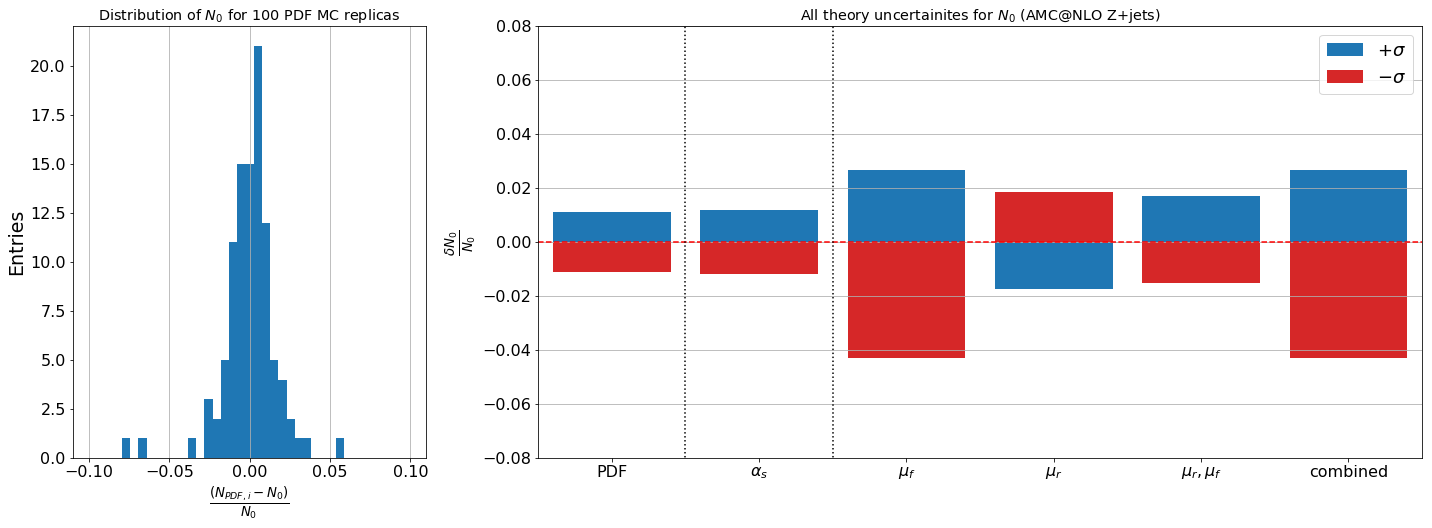

In [17]:
#### examine variation in n_init
fig, axes = plt.subplots(1, 2, figsize=(20, 8), facecolor='white', gridspec_kw={'width_ratios':[2,5]})

# plot replicas and calculate variance
ax = axes[0]
diff_pdf = np.sort((pdf_hist_init - n_init_nominal)/n_init_nominal)
ax.hist(diff_pdf, bins=np.linspace(-0.1, 0.1, 40))
ax.grid(axis='x')
ax.set_ylabel('Entries')
ax.set_xlabel(r'$\frac{(N_{PDF,i} - N_{0})}{N_{0}}$')
ax.set_title('Distribution of $N_{0}$ for 100 PDF MC replicas')

# calculate PDF uncertainty
mean_pdf = (diff_pdf[84] + diff_pdf[16])/2
sigma_pdf = (diff_pdf[84] - diff_pdf[16])/2

# calculate alpha_s uncertainty
diff_alpha_s = (n_init_nominal - n_init_alpha_s)/n_init_nominal

# calculate mu_r/mu_f variations
diff_qcd = (qcd_hist_init - n_init_nominal)/n_init_nominal
diff_muf = diff_qcd[[1, 0]]
diff_mur = diff_qcd[[3, 2]]
diff_mur_muf = diff_qcd[[5, 4]]
diff_qcd_envelope = [diff_qcd.min(), diff_qcd.max()]

# combined uncertainties: need to take some care here.  This is complicated because the 
# mu_r/mu_f variations are one sided.  To account for this I will construct +/-sigma by 
# adding in quadrature +/- variation separately.
sigma_up = np.array([diff_pdf[84], diff_alpha_s, diff_muf[1], diff_mur[1], diff_mur_muf[1], diff_qcd_envelope[1]]) 
sigma_down = np.array([diff_pdf[16], -diff_alpha_s, diff_muf[0], diff_mur[0], diff_mur_muf[0], diff_qcd_envelope[0]]) 

# plot alpha_s, mu_r, and mu_f variation
ax = axes[1]
xticks =np.linspace(1, sigma_up.size, sigma_up.size) 
ax.bar(xticks, height=sigma_up, color='C0', label=r'$+\sigma$')
ax.bar(xticks, height=sigma_down, color='C3', label=r'$-\sigma$')
ax.plot([0.5, sigma_up.size+0.5], [0, 0], 'r--', label='_nolegend_')
ax.plot([1.5, 1.5], [-1, 1], 'k:', label='_nolegend_')
ax.plot([2.5, 2.5], [-1, 1], 'k:', label='_nolegend_')
ax.set_xlim(0.5, sigma_up.size+0.5)
ax.set_ylim(-0.08, 0.08)
ax.grid(axis='y')
ax.set_ylabel(r'$\frac{\delta N_{0}}{N_{0}}$')
ax.set_xticks(xticks)
ax.set_xticklabels(p_labels)
ax.set_title('All theory uncertainites for $N_{0}$ (AMC@NLO Z+jets)')
ax.legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [19]:
# get the data
root_file = r.TFile('local_data/bltuples/output_pdf.root')
hist = root_file.Get('var_PDF_partons_init_zjets_m-50_alt')
pdf_hist_init = np.array([[hist.GetBinContent(x+1, y+1) for x in range(hist.GetNbinsX())] for y in range(hist.GetNbinsY())])
n_init_alpha_s = pdf_hist_init[:,-1]
#hist_init = np.array([hist_init[:-1] for _ in range(4)]) # last entry is +1 sigma alpha_s

# get initial values for each QCD variation (mu_r, mu_f)
hist = root_file.Get('var_QCD_partons_init_zjets_m-50_alt')
qcd_hist_init = np.array([[hist.GetBinContent(x+1, y+1) for x in range(hist.GetNbinsX())] for y in range(hist.GetNbinsY())])

# separate nominal value and mask unphysical (contrapuntal) variations
n_init_nominal = qcd_hist_init[:,0]
qcd_hist_init = qcd_hist_init[:,[1,2,3,6,4,8]]

# close the root file (a new file is opened each time this cell is run)
root_file.Close()

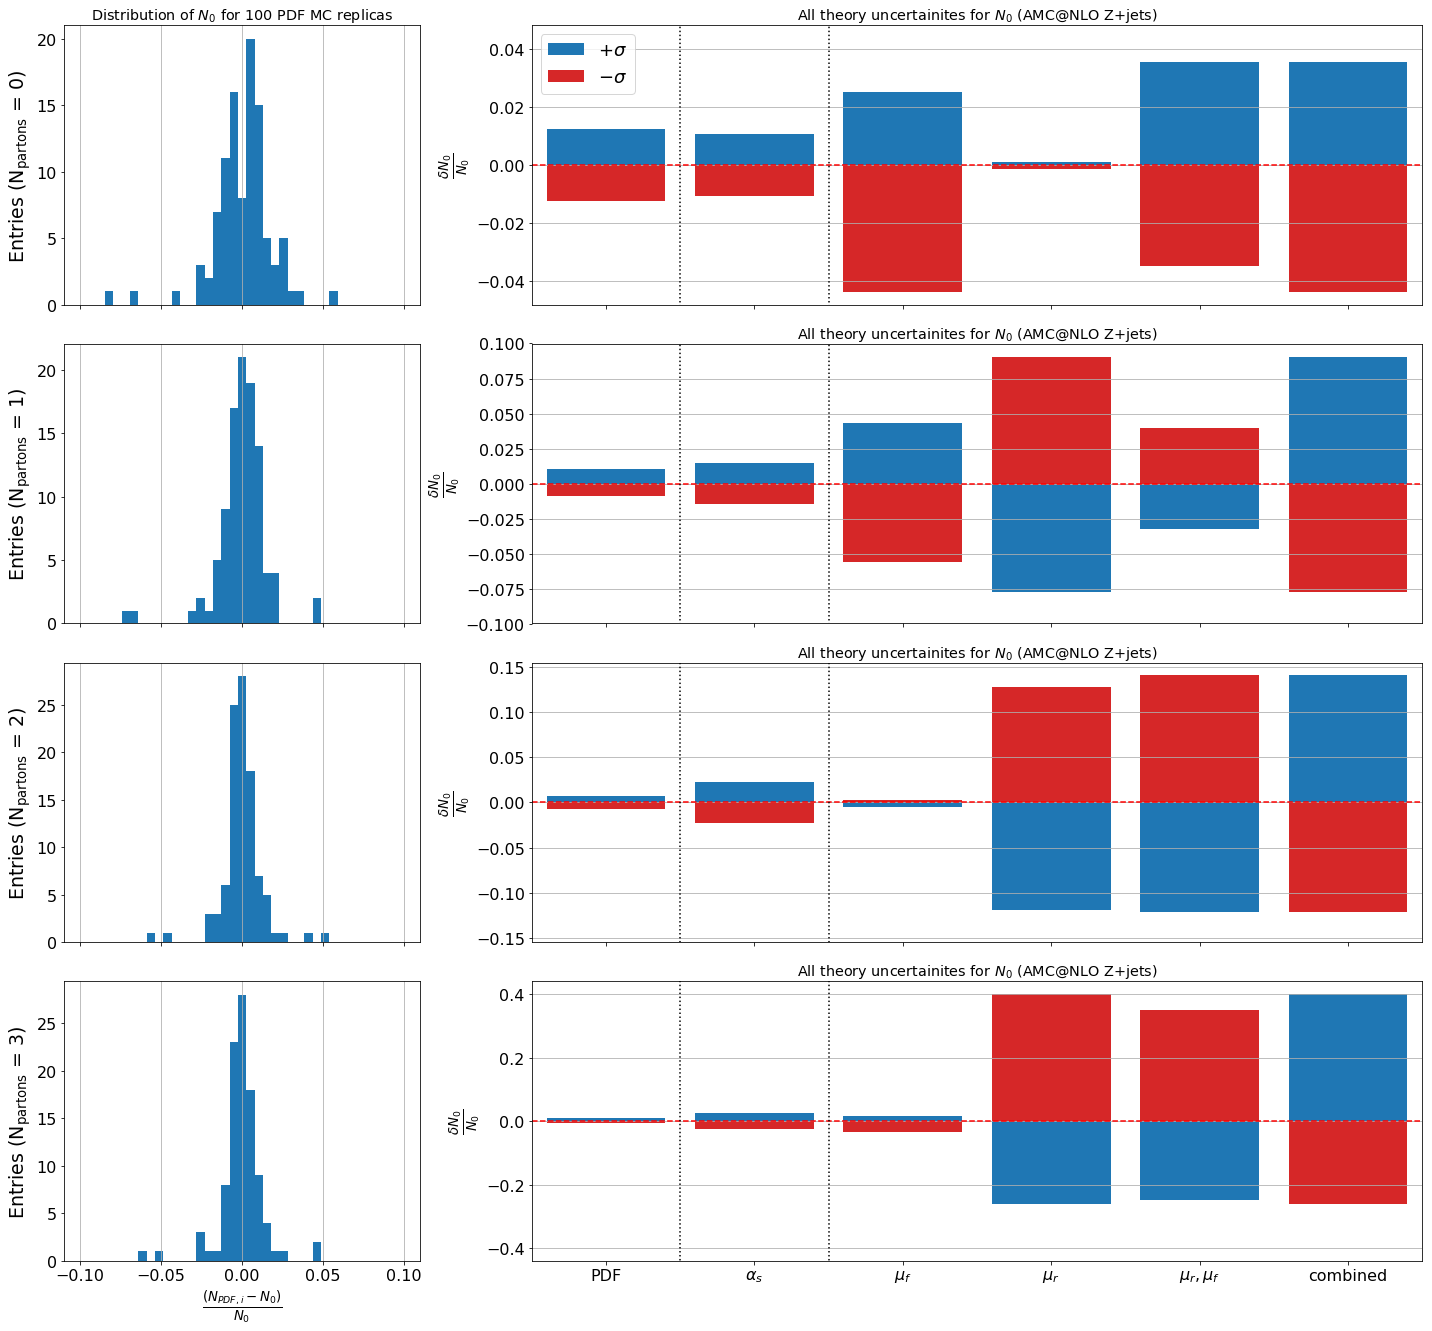

In [20]:
# examine variation in n_init
fig, axes = plt.subplots(4, 2, figsize=(20, 20), facecolor='white', gridspec_kw={'width_ratios':[2,5]}, sharex='col')

sigma_pdf_partons = []
for npartons in range(4):
    
    # plot replicas and calculate variance
    ax = axes[npartons][0]
    diff_pdf = (pdf_hist_init[npartons] - n_init_nominal[npartons])/n_init_nominal[npartons]
    ax.hist(diff_pdf, bins=np.linspace(-0.1, 0.1, 40))
    ax.grid(axis='x')
    ax.set_ylabel('Entries ($\sf N_{partons}$ = ' + f'{npartons})')
    
    if npartons == 0:
        ax.set_title('Distribution of $N_{0}$ for 100 PDF MC replicas')
    if npartons == 3:
        ax.set_xlabel(r'$\frac{(N_{PDF,i} - N_{0})}{N_{0}}$')

    # scale efficiency to percent of mean
    diff_pdf = np.sort(diff_pdf)
    mean_pdf = (diff_pdf[84] + diff_pdf[16])/2
    sigma_pdf = (diff_pdf[84] - diff_pdf[16])/2

    diff_alpha_s = (n_init_nominal[npartons] - n_init_alpha_s[npartons])/n_init_nominal[npartons]
    
    # calculate mu_r/mu_f variations
    diff_qcd = (qcd_hist_init[npartons] - n_init_nominal[npartons])/n_init_nominal[npartons]
    diff_muf = diff_qcd[[1, 0]]
    diff_mur = diff_qcd[[3, 2]]
    diff_mur_muf = diff_qcd[[5, 4]]
    diff_qcd_envelope = [diff_qcd.min(), diff_qcd.max()]

    # combined uncertainties: need to take some care here.  This is complicated because the 
    # mu_r/mu_f variations are one sided.  To account for this I will construct +/-sigma by 
    # adding in quadrature +/- variation separately.
    sigma_up = np.array([diff_pdf[84], diff_alpha_s, diff_muf[1], diff_mur[1], diff_mur_muf[1], diff_qcd_envelope[1]]) 
    sigma_down = np.array([diff_pdf[16], -diff_alpha_s, diff_muf[0], diff_mur[0], diff_mur_muf[0], diff_qcd_envelope[0]]) 
    bmax = np.max(np.abs(np.concatenate([sigma_up, sigma_down])))
    #print(sigma_up, sigma_down)
    
    # plot alpha_s, mu_r, and mu_f variation
    ax = axes[npartons][1]
    xticks =np.linspace(1, sigma_up.size, sigma_up.size) 
    b1 = ax.bar(xticks, height=sigma_up, color='C0', label=r'$+\sigma$')
    b2 = ax.bar(xticks, height=sigma_down, color='C3', label=r'$-\sigma$')
    ax.plot([0.5, sigma_up.size+0.5], [0, 0], 'r--', label='_nolegend_')
    ax.plot([1.5, 1.5], [-1, 1], 'k:', label='_nolegend_')
    ax.plot([2.5, 2.5], [-1, 1], 'k:', label='_nolegend_')
    ax.set_xlim(0.5, sigma_up.size+0.5)
    ax.set_ylim(-1.1*bmax, 1.1*bmax)
    ax.grid(axis='y')
    ax.set_ylabel(r'$\frac{\delta N_{0}}{N_{0}}$')
    ax.set_xticks(xticks)
    ax.set_xticklabels(p_labels)
    ax.set_title('All theory uncertainites for $N_{0}$ (AMC@NLO Z+jets)')
    
    if npartons == 0:
        ax.set_title('All theory uncertainites for $N_{0}$ (AMC@NLO Z+jets)')
        ax.legend()
    if npartons == 3:
        ax.set_xticks(xticks)
        ax.set_xticklabels(p_labels)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('plots/systematics/theory_variations_zjets.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


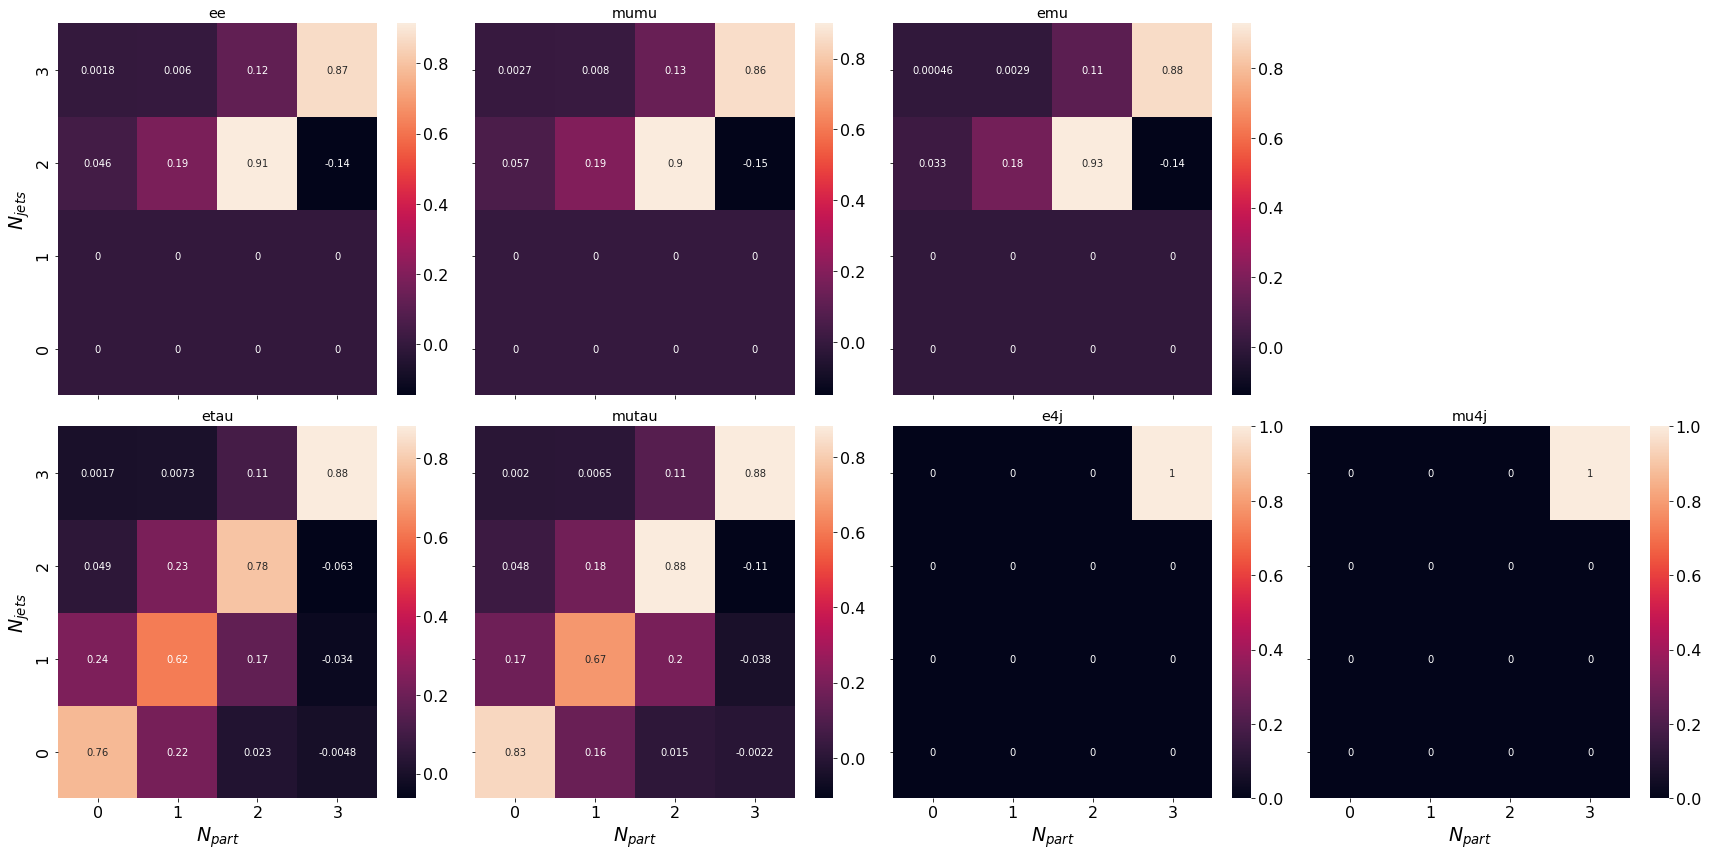

In [12]:
# get channel specific PDF, alpha_s, and QCD variations after application of channel selection
import pickle
import seaborn as sns

fig, axes = plt.subplots(2, 4, figsize=(24, 12), facecolor='white', sharex=True, sharey=True)
jet_cuts = dict(ee = 2, mumu = 2, emu = 2, etau = 0, mutau = 0, e4j = 4, mu4j = 4)

r_parton_to_jets = dict()
for i, sel in enumerate(selections):
    if i >= 3:
        i = i+1
        
    ax = axes[i//4, i%4]
    input_file = open(f'local_data/flatuples/pdf_var/{sel}_2016/ntuple_zjets_m-50_alt.pkl', 'rb')
    df = pickle.load(input_file)
    df = df.query(f'n_jets >= {jet_cuts[sel]}')
    df[df['n_jets'] > 3] = 3
    hist, x, y = np.histogram2d(df['n_jets'], df['n_partons'], bins=[np.linspace(-0.5, 3.5, 5), np.linspace(-0.5, 3.5, 5)], weights=df['weight']*df['gen_weight'])
    for j in range(hist.shape[1]):
        hist[j,:] /= hist[j,:].sum()
    hist[np.isnan(hist)] = 0
    sns.heatmap(hist, annot=True, ax=ax)
    ax.invert_yaxis()
    ax.set_title(sel)
    
    if i%4 == 0:
        ax.set_ylabel(r'$N_{jets}$')
    if i//4 == axes.shape[0] - 1:
        ax.set_xlabel(r'$N_{part}$')
        
    r_parton_to_jets[sel] = hist

axes[0, 3].axis('off')
plt.tight_layout()
plt.savefig('plots/jet_to_parton_zjets.pdf')
plt.show()

In [9]:
# update uncertainties in data/xs_zjets_error.csv
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

err = pd.DataFrame({sel:np.sqrt(np.dot(np.array(sigma_pdf_partons)**2, r_parton_to_jets[sel].T**2)) for sel in selections})
err = err.fillna(0)
err.to_latex('local_data/xs_zjets_error.tex', escape=False)
err

ValueError: shapes (0,) and (4,4) not aligned: 0 (dim 0) != 4 (dim 0)

In [ ]:
err_total = pd.read_csv('data/xs_zjets_error.csv').set_index('category')
for njets in range(4):
    err_total.loc[err_total.njets == njets, selections] = err.loc[njets].values

err_total = err_total.fillna(0)
err_total.to_csv('data/xs_zjets_error.csv')
err_total

In [ ]:
# get channel specific PDF, alpha_s, and QCD variations after application of channel selection
root_file = r.TFile('local_data/bltuples/output_pdf.root')
effs = dict()
for sel in selections:
    hist = root_file.Get(f'{sel}/var_PDF_jets_{sel}_zjets_m-50_alt')
    hist = np.array([[hist.GetBinContent(x+1, y+1) for x in range(hist.GetNbinsX())] for y in range(hist.GetNbinsY())])
    eff_nominal = hist[:,0]
    eff_alpha_s = hist[:,-1]
    #print(sel, (eff_alpha_s - eff_nominal)/eff_alpha_s)
    effs[sel] = hist

In [ ]:
# make plots for pdf variations

fig, axes = plt.subplots(4, 7, figsize=(20, 20), facecolor='white')
fig.suptitle(r'PDF variations for AMC@NLO Drell-Yan ($M_{\ell\ell} > 50$ GeV)')

err_pdf = {sel:np.array([0., 0., 0., 0.]) for sel in selections}
for isel, sel in enumerate(selections):
    for njet in np.arange(4):
        ax = axes[njet][isel]
        eff = np.sort(effs[sel][njet])
        
        # scale efficiency to percent of mean
        mean =  (eff[84] + eff[16])/2
        sigma = (eff[84] - eff[16])/2
        sigma /= abs(mean)
        err_pdf[sel][njet] = sigma
        
        ax.hist(eff/mean, bins=np.linspace(0.8, 1.1, 35), histtype='stepfilled', alpha=0.8)
        ax.text(0.1, 0.8, r'$\frac{\delta\epsilon}{<\epsilon>}$ = ' + f'{sigma:.1%}', transform=ax.transAxes, size=16)
        ax.set_xlim(0.8, 1.1)
        
        if isel == 0 and njet < 3:
            ax.set_ylabel(r'$\sf n_{jets}$ = ' + str(njet), size=18)
            
        if njet == 0:
            ax.set_title(sel)
            
        if njet == 3:
            ax.set_xlabel(r'$\frac{\epsilon - \bar{\epsilon}}{\bar{\epsilon}}$', size=16)
            #ax.set_xlabel(r'$\frac{N - \bar{N}}{\bar{N}}$', size=16)
            
            if isel == 0:
                ax.set_ylabel(r'$\sf n_{jets} \geq 3$ ', size=18)
        
fig.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('plots/systematics/pdf_variations_zjets.pdf')
plt.show()